<a href="https://colab.research.google.com/github/sun-gif/Capstone-Project-2-Milestone-Report-2/blob/master/Medical_image_segmentation_for_%E2%80%8BProstate_cancer_samples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#load file
import os
os.environ['KAGGLE_USERNAME'] = "xxxxxxxxx" # username from the json file
os.environ['KAGGLE_KEY'] = "xxxxxxxxxx" # key from the json file
#!kaggle datasets download -d Competetion/Prostate-cANcer-graDe-Assessment-(PANDA)-Challenge
!kaggle datasets download -d xhlulu/panda-resized-train-data-512x512 # api copied from kaggle

 99% 1.01G/1.02G [00:31<00:00, 45.3MB/s]
100% 1.02G/1.02G [00:31<00:00, 34.5MB/s]


In [ ]:
!unzip \*.zip

In [4]:
# define path
mask_dir = 'train_label_masks/train_label_masks'
data_dir='train_images/train_images'

In [5]:
# import lib
import random
from PIL import Image
import torchvision.transforms.functional as TF

import torch
import skimage.io
from torch.utils.data import Dataset, DataLoader, RandomSampler,random_split
from natsort import natsorted
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import skimage.io
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import PIL
import cv2

from pathlib import Path
import pandas as pd
from tqdm import tqdm

import io

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [6]:
# load label csv file
from google.colab import files

uploaded = files.upload()


Saving train.csv to train.csv


In [7]:

trainc= pd.read_csv(io.BytesIO(uploaded['train.csv']))
trainc.isna().sum()

image_id         0
data_provider    0
isup_grade       0
gleason_score    0
dtype: int64

In [ ]:
trainc.head()

,image_id,data_provider,isup_grade,gleason_score
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0


In [ ]:
#  data analysis on train csv file
print("unique ids : ", len(trainc.image_id.unique()))
print("unique data provider : ", len(trainc.data_provider.unique()))
print("unique isup_grade(target) : ", len(trainc.isup_grade.unique()))
print("unique gleason_score : ", len(trainc.gleason_score.unique()))

unique ids :  10616
unique data provider :  2
unique isup_grade(target) :  6
unique gleason_score :  11


In [8]:
#create 2 different dataset: rgrade:all data from radboud center ;grade5rt: only class==5 from radbound center
trainr=trainc[trainc.data_provider=='radboud']
traink=trainc[trainc.data_provider=='karolinska']
grade5rt=trainr[trainr.isup_grade==5].image_id.values
rgrade=trainr.image_id.values
grade=trainc.image_id.values

In [ ]:
#create a small dataset from radboud for visulaziation of each class
grade0r=trainr[trainr.isup_grade==0].image_id.values[:1]
grade1r=trainr[trainr.isup_grade==1].image_id.values[:1]
grade2r=trainr[trainr.isup_grade==2].image_id.values[:1]
grade3r=trainr[trainr.isup_grade==3].image_id.values[:1]
grade4r=trainr[trainr.isup_grade==4].image_id.values[:1]
grade5r=trainr[trainr.isup_grade==5].image_id.values[:1]
gradeset=np.concatenate((grade0r,grade1r,grade2r,grade3r,grade4r,grade5r))
len(gradeset)

6

In [ ]:
##create a small dataset from Karolinska for visulaziation of each class
grade0k=traink[traink.isup_grade==0].image_id.values[:1]
grade1k=traink[traink.isup_grade==1].image_id.values[:1]
grade2k=traink[traink.isup_grade==2].image_id.values[:1]
grade3k=traink[traink.isup_grade==3].image_id.values[:1]
grade4k=traink[traink.isup_grade==4].image_id.values[:1]
grade5k=traink[traink.isup_grade==5].image_id.values[:1]
gradesetk=np.concatenate((grade0k,grade1k,grade2k,grade3k,grade4k,grade5k))

In [ ]:
train=trainc.set_index('image_id')

In [ ]:
# define an funtion to show image ,label and its mask
def display_images(slides): 
    f, ax = plt.subplots(6,2, figsize=(18,32))
    for i, slide in enumerate(slides):
        biopsy = skimage.io.MultiImage(os.path.join(data_dir, slide+'.png'))
        image = cv2.cvtColor(biopsy[0], cv2.COLOR_BGR2RGB)
        ax[i, 0].imshow(image) 
        
        maskfile = skimage.io.MultiImage(os.path.join(mask_dir, slide+'_mask.png'))
        mask_level_2 = maskfile[-1][:,:,-1]
 
        cmap = matplotlib.colors.ListedColormap(['black', 'gray', 'green', 'yellow', 'orange', 'red'])
     
        ax[i, 1].imshow(mask_level_2,cmap=cmap,interpolation='nearest', vmin=0, vmax=5)

       
        
        image_id = slide
        data_provider = train.loc[slide, 'data_provider']
        isup_grade = train.loc[slide, 'isup_grade']
        gleason_score = train.loc[slide, 'gleason_score']
        ax[i, 0].set_title(f"ID: {image_id}\nSource: {data_provider} ISUP: {isup_grade} Gleason: {gleason_score}")

    plt.show() 

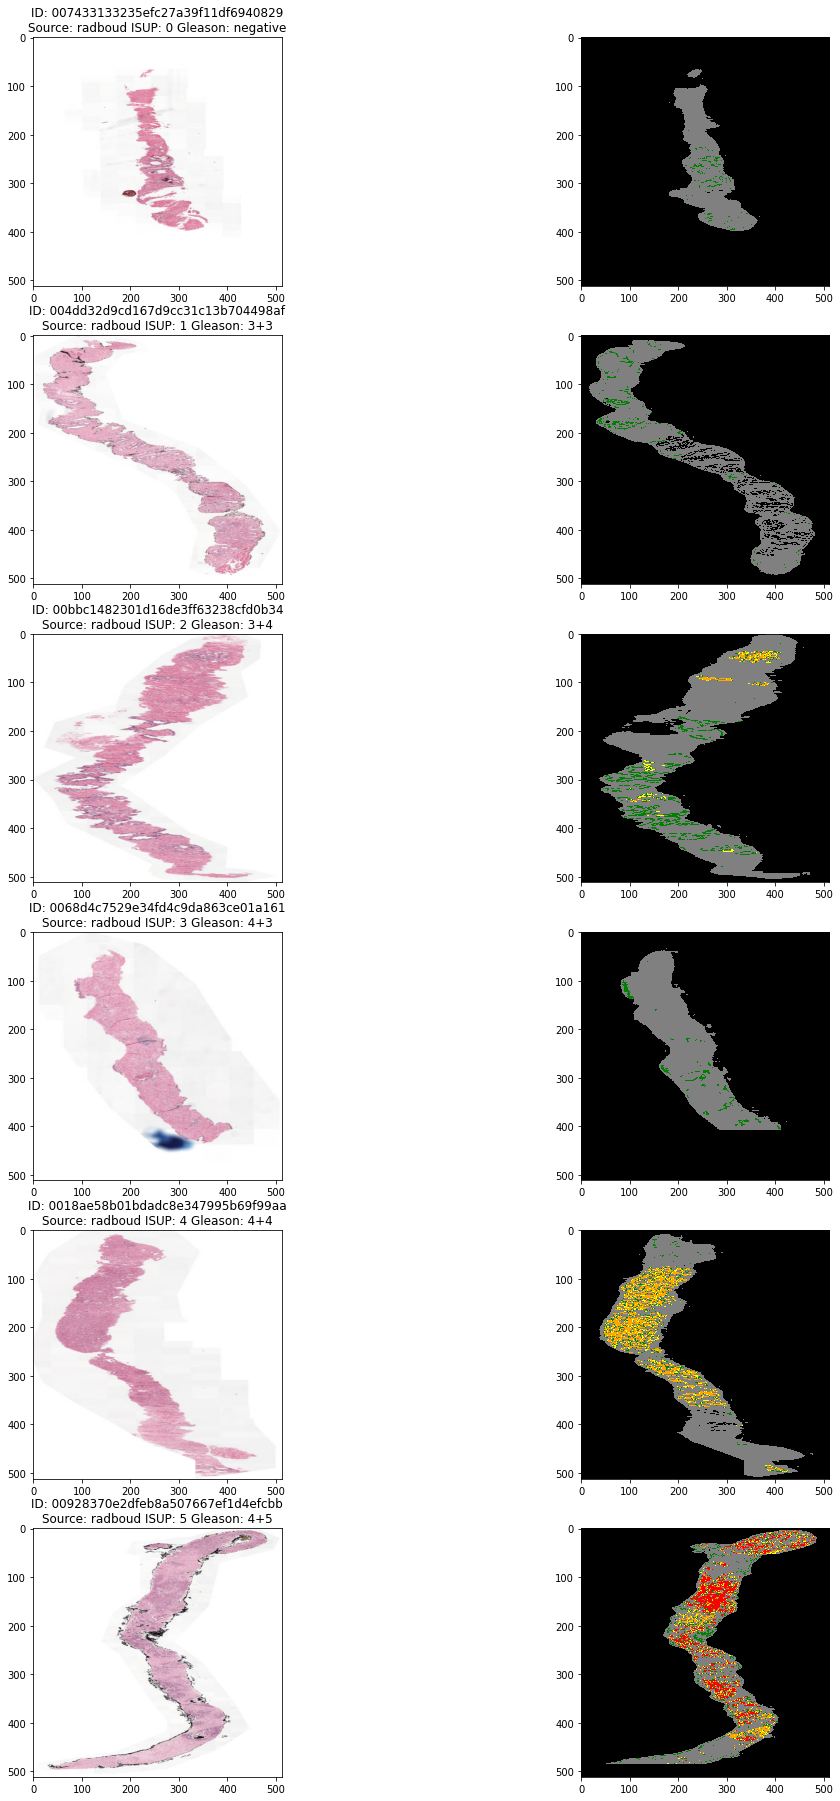

In [ ]:
# show image and its corresponding mask from radboud center for 6 different classes
display_images(gradeset)

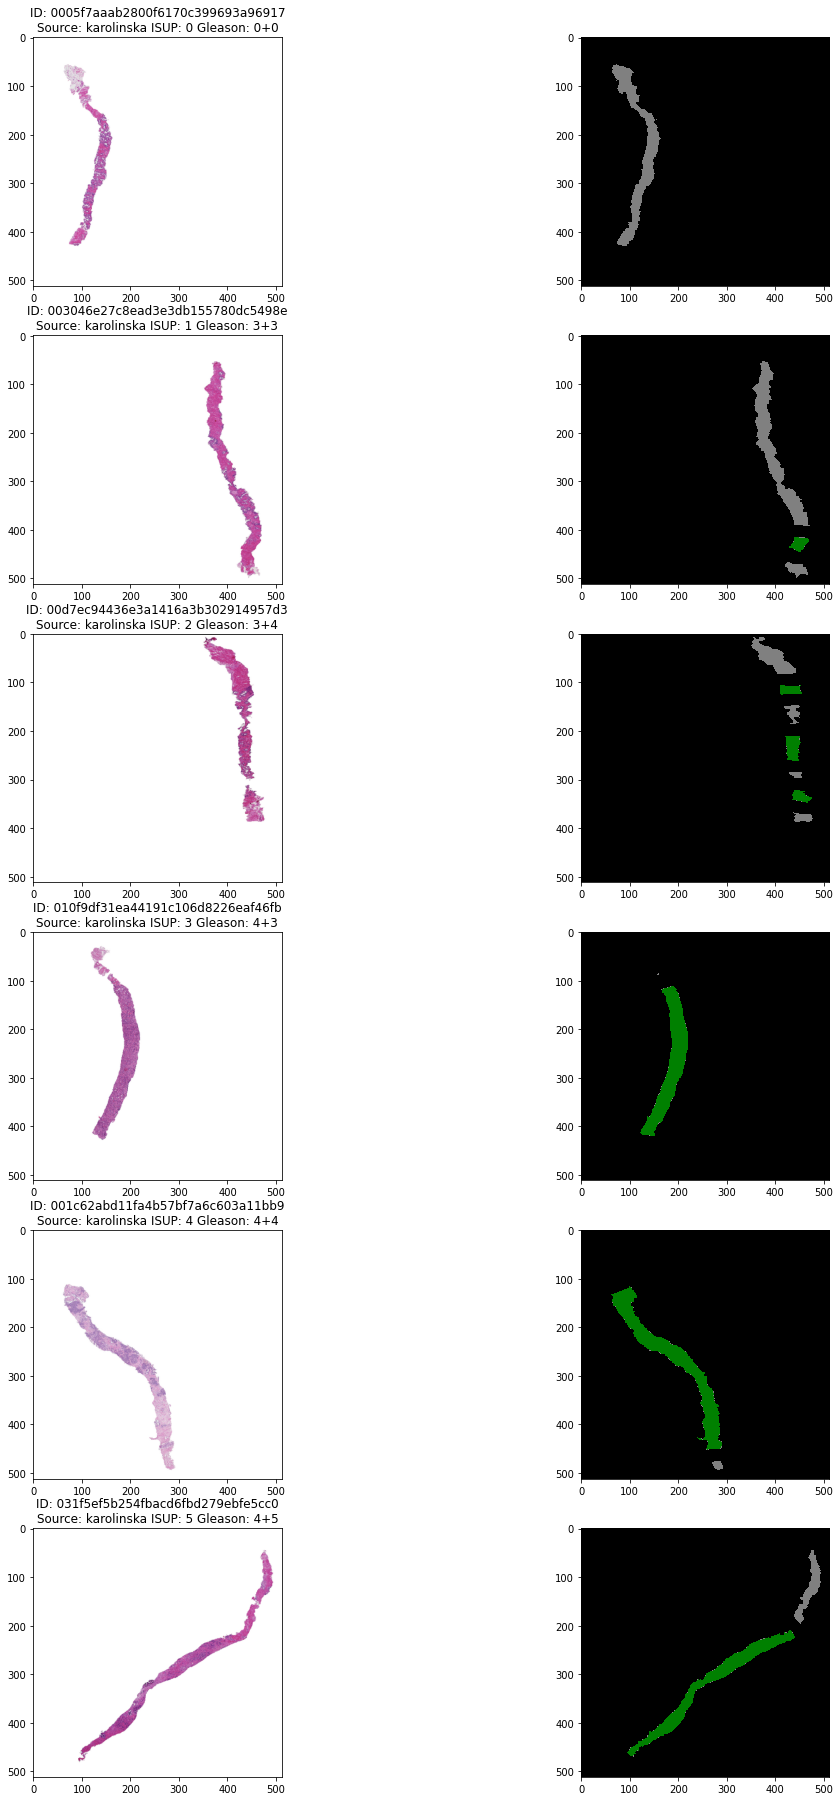

In [ ]:
## show image and its corresponding mask from Karolinska center for 6 different classes
display_images(gradesetk)


In [ ]:
# label distribution from both centers
temp = trainc.groupby('isup_grade').count()['image_id'].reset_index().sort_values(by='image_id',ascending=False)
#temp.style.background_gradient(cmap='Purples')
temp

,isup_grade,image_id
0,0,2892
1,1,2666
2,2,1343
4,4,1249
3,3,1242
5,5,1224


In [ ]:
# label distribution from radbound
rtemp=trainc[trainc['data_provider']=='radboud'].groupby('isup_grade').count()['image_id'].reset_index().sort_values(by='image_id',ascending=False)

Text(0.5, 1.0, 'numbers of each class from radboud')

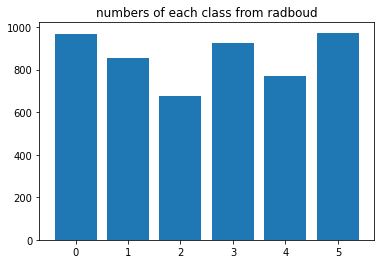

In [ ]:

fig = plt.bar(rtemp.isup_grade,  height=rtemp.image_id )
plt.title('numbers of each class from radboud')

Text(0.5, 1.0, 'numbers of each class')

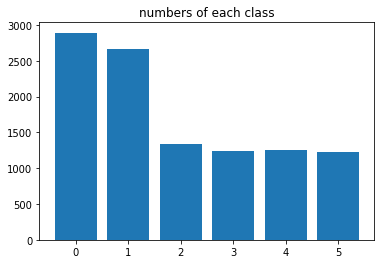

In [ ]:

fig = plt.bar(temp.isup_grade,  height=temp.image_id )
plt.title('numbers of each class')

We see that the isup_grade 0 and 1 i.e no cancer, has the most number of values and that's what expected in case of most medical datasets , the target class will always be underrepresented and that's also the most important challenge when performing machine learning tasks on Medical DATA

In [10]:
# customized dataset
class MyDataset(Dataset):
    def __init__(self, image_paths, target_paths, train=True):
        self.image_paths = image_paths
        self.target_paths = target_paths

    def transform(self, image):
        # Resize
        #resize = transforms.Resize(size=(520, 520))
        #image = resize(image)
        #mask = resize(mask)

        # Random crop
        #i, j, h, w = transforms.RandomCrop.get_params(
        #    image, output_size=(512, 512))
        #image = TF.crop(image, i, j, h, w)
        #mask = TF.crop(mask, i, j, h, w)

        # Random horizontal flipping
        #if random.random() > 0.5:
         #  image = TF.hflip(image)
          # mask = TF.hflip(mask)

        # Random vertical flipping
        #if random.random() > 0.5:
         #   image = TF.vflip(image)
          #  mask = TF.vflip(mask)

        # Transform to tensor
        image = TF.to_tensor(image)
       # mask = TF.to_tensor(mask)
        return image

    def __getitem__(self, index):
        image = Image.open(self.image_paths[index])
        #mask=Image.open(self.target_paths[index])
        mask=skimage.io.MultiImage(self.target_paths[index])
        #x,mask = self.transform(image,mask)
        

        
        mask=mask[-1][:,:,-1]
        #mask=mask[-1,:,:]
        y= torch.from_numpy(np.array(mask)) 
        x = self.transform(image)
        return x, y

    def __len__(self):
        return len(self.target_paths)

In [11]:
#create path pair
def path(subdataid):
   subfilenames = [name+'_mask.png' for name in subdataid]
   filenames = [name for name in os.listdir(mask_dir) if os.path.splitext(name)[-1] == '.png']
   sfilenames=list(set(subfilenames) & set(filenames))
   image_paths=[]
   masks_paths=[]
   for i, filename in enumerate(sfilenames):  

     image=os.path.join(data_dir, filename.split('_')[0]+'.png') 
     masks=os.path.join(mask_dir,filename)
     image_paths.append(image)
     masks_paths.append(masks)
#image_path.items
   return image_paths,masks_paths

In [12]:
# create dataloader
def dataloaderpipline(subdataset):
  image_paths,masks_paths=path(subdataset)
  dataset = MyDataset(image_paths,masks_paths)
  train_ds, valid_ds = torch.utils.data.random_split(dataset, (1000, (len(dataset)-1000)))
  train_loader = DataLoader(train_ds , batch_size=1, shuffle=False, 
                        num_workers=4, drop_last=True)
  valid_loader = DataLoader(valid_ds , batch_size=1, shuffle=False, 
                         num_workers=4, drop_last=True)
  return train_loader,valid_loader


In [15]:
# train_test split
trainr_loader,validr_loader=dataloaderpipline(rgrade)
#traint_loader,test_loader=dataloaderpipline(grade[:1500])
train5_loader,valid_loader=dataloaderpipline(grade5rt)

In [16]:

# create u_net model



class BaseConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding,
                 stride):
        super(BaseConv, self).__init__()

        self.act = nn.ReLU()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, padding,
                               stride)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size,
                               padding, stride)

    def forward(self, x):
        x = self.act(self.conv1(x))
        x = self.act(self.conv2(x))
        return x


class DownConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding,
                 stride):
        super(DownConv, self).__init__()

        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv_block = BaseConv(in_channels, out_channels, kernel_size,
                                   padding, stride)

    def forward(self, x):
        x = self.pool1(x)
        x = self.conv_block(x)
        return x


class UpConv(nn.Module):
    def __init__(self, in_channels, in_channels_skip, out_channels,
                 kernel_size, padding, stride):
        super(UpConv, self).__init__()

        self.conv_trans1 = nn.ConvTranspose2d(
            in_channels, in_channels, kernel_size=2, padding=0, stride=2)
        self.conv_block = BaseConv(
            in_channels=in_channels + in_channels_skip,
            out_channels=out_channels,
            kernel_size=kernel_size,
            padding=padding,
            stride=stride)

    def forward(self, x, x_skip):
        x = self.conv_trans1(x)
        x = torch.cat((x, x_skip), dim=1)
        x = self.conv_block(x)
        return x


class UNet(nn.Module):
    def __init__(self, in_channels, out_channels, n_class, kernel_size,
                 padding, stride):
        super(UNet, self).__init__()

        self.init_conv = BaseConv(in_channels, out_channels, kernel_size,
                                  padding, stride)

        self.down1 = DownConv(out_channels, 2 * out_channels, kernel_size,
                              padding, stride)

        self.down2 = DownConv(2 * out_channels, 4 * out_channels, kernel_size,
                              padding, stride)

        self.down3 = DownConv(4 * out_channels, 8 * out_channels, kernel_size,
                              padding, stride)

        self.up3 = UpConv(8 * out_channels, 4 * out_channels, 4 * out_channels,
                          kernel_size, padding, stride)

        self.up2 = UpConv(4 * out_channels, 2 * out_channels, 2 * out_channels,
                          kernel_size, padding, stride)

        self.up1 = UpConv(2 * out_channels, out_channels, out_channels,
                          kernel_size, padding, stride)

        self.out = nn.Conv2d(out_channels, n_class, kernel_size, padding, stride)

    def forward(self, x):
        # Encoder
        x = self.init_conv(x)
        x1 = self.down1(x)
        x2 = self.down2(x1)
        x3 = self.down3(x2)
        # Decoder
        x_up = self.up3(x3, x2)
        x_up = self.up2(x_up, x1)
        x_up = self.up1(x_up, x)
        x_out = self.out(x_up)
        x_out = F.log_softmax(self.out(x_up), 1)
        return x_out




In [ ]:
#define train function using Nllloss to train,and also as evaluation metric for test sets
def train(train_loader,n,m,test_loader):

  model = UNet(in_channels=3,
             out_channels=64,
             n_class=6,
             kernel_size=3,
             padding=1,
             stride=1)
# Create 6-class segmentation dummy image and target
  nb_classes = 6
  criterion = nn.NLLLoss()
  optimizer = optim.Adam(model.parameters(), lr=1e-3)
  Loss=[]
  for epoch in range(m):  # loop over the dataset multiple times

    running_loss = 0.
    for x,y in target_loader:

       y = y.type(torch.LongTensor)
       if torch.cuda.is_available():

          model = model.to('cuda')
          x = x.to('cuda')
          y = y.to('cuda')
       optimizer.zero_grad()
       output = model(x)
    #y = y.type(torch.LongTensor)
       loss = criterion(output, y)
    #loss=diceLoss(diceLoss,y,output,epsilon=1,p=False)
       loss.backward()
       optimizer.step()
     
      #print('Epoch {}, Loss {}'.format(epoch, loss.item()))
        # print statistics
       running_loss += loss.item()
       #print('Epoch {}, Loss {}'.format(epoch, loss.item()))
    
        
    print( 'Epoch {},running_Loss {}'.format(epoch,running_loss/len(target_loader))) 
    
    Loss.append(running_loss/len(target_loader))    
  plt.plot(Loss)
  plt.show
  for x,y in test:

       y = y.type(torch.LongTensor)
       if torch.cuda.is_available():

          model = model.to('cuda')
          x = x.to('cuda')
          y = y.to('cuda')
       #optimizer.zero_grad()
       output = model(x)
    #y = y.type(torch.LongTensor)
       loss = criterion(output, y)
       #loss=diceLoss(diceLoss,y,output,epsilon=1,p=False)
      # loss.backward()
       #optimizer.step()
     
      #print('Epoch {}, Loss {}'.format(epoch, loss.item()))
        # print statistics
       running_loss += loss.item()
       #print('Epoch {}, Loss {}'.format(epoch, loss.item()))
    
        
  print( 'running_Loss {}'.format(running_loss/len(test)))   
  f, ax = plt.subplots(n,2, figsize=(18,32))
  m=iter(test)
  for i in range(n):
    x,y=next(m)
    cmap = matplotlib.colors.ListedColormap(['black', 'gray', 'green', 'yellow', 'orange', 'red'])
    ax[i, 0].imshow(y[-1],cmap=cmap,interpolation='nearest', vmin=0, vmax=5) 
   # plt.show()
    
    if torch.cuda.is_available():
          model = model.to('cuda')
          x = x.to('cuda')
    output = model(x)
    
    f=output[0].cpu().detach().numpy() 
    f=f.argmax(axis=0)
    #print(f.shape,y[-1].shape)
    #f=f.torch.float()
    cmap = matplotlib.colors.ListedColormap(['black', 'gray', 'green', 'yellow', 'orange', 'red'])
    ax[i, 1].imshow(f,cmap=cmap,interpolation='nearest', vmin=0, vmax=5)
    #plt.colorbar()
    #plt.show()

   

Epoch 0,running_Loss 0.3500984207130969
Epoch 1,running_Loss 0.30758999068289994
Epoch 2,running_Loss 0.24506564624235033
Epoch 3,running_Loss 0.2204496706649661
Epoch 4,running_Loss 0.2215602302737534
Epoch 5,running_Loss 0.22537476571276785
Epoch 6,running_Loss 0.20290437755547464
Epoch 7,running_Loss 0.20668517525680363
Epoch 8,running_Loss 0.23352119585126638
Epoch 9,running_Loss 0.19519090950116516
Epoch 10,running_Loss 0.19094862558692693
Epoch 11,running_Loss 0.18682610807567834
Epoch 12,running_Loss 0.1834360602144152
Epoch 13,running_Loss 0.18665594256669282
Epoch 14,running_Loss 0.18263051123172044
Epoch 15,running_Loss 0.18659084192477166
Epoch 16,running_Loss 0.17968575068190693
Epoch 17,running_Loss 0.20791743956133724
Epoch 18,running_Loss 0.1820181287266314
Epoch 19,running_Loss 0.17791740744002163
running_Loss 0.21492987511807987


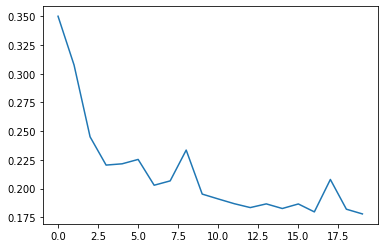

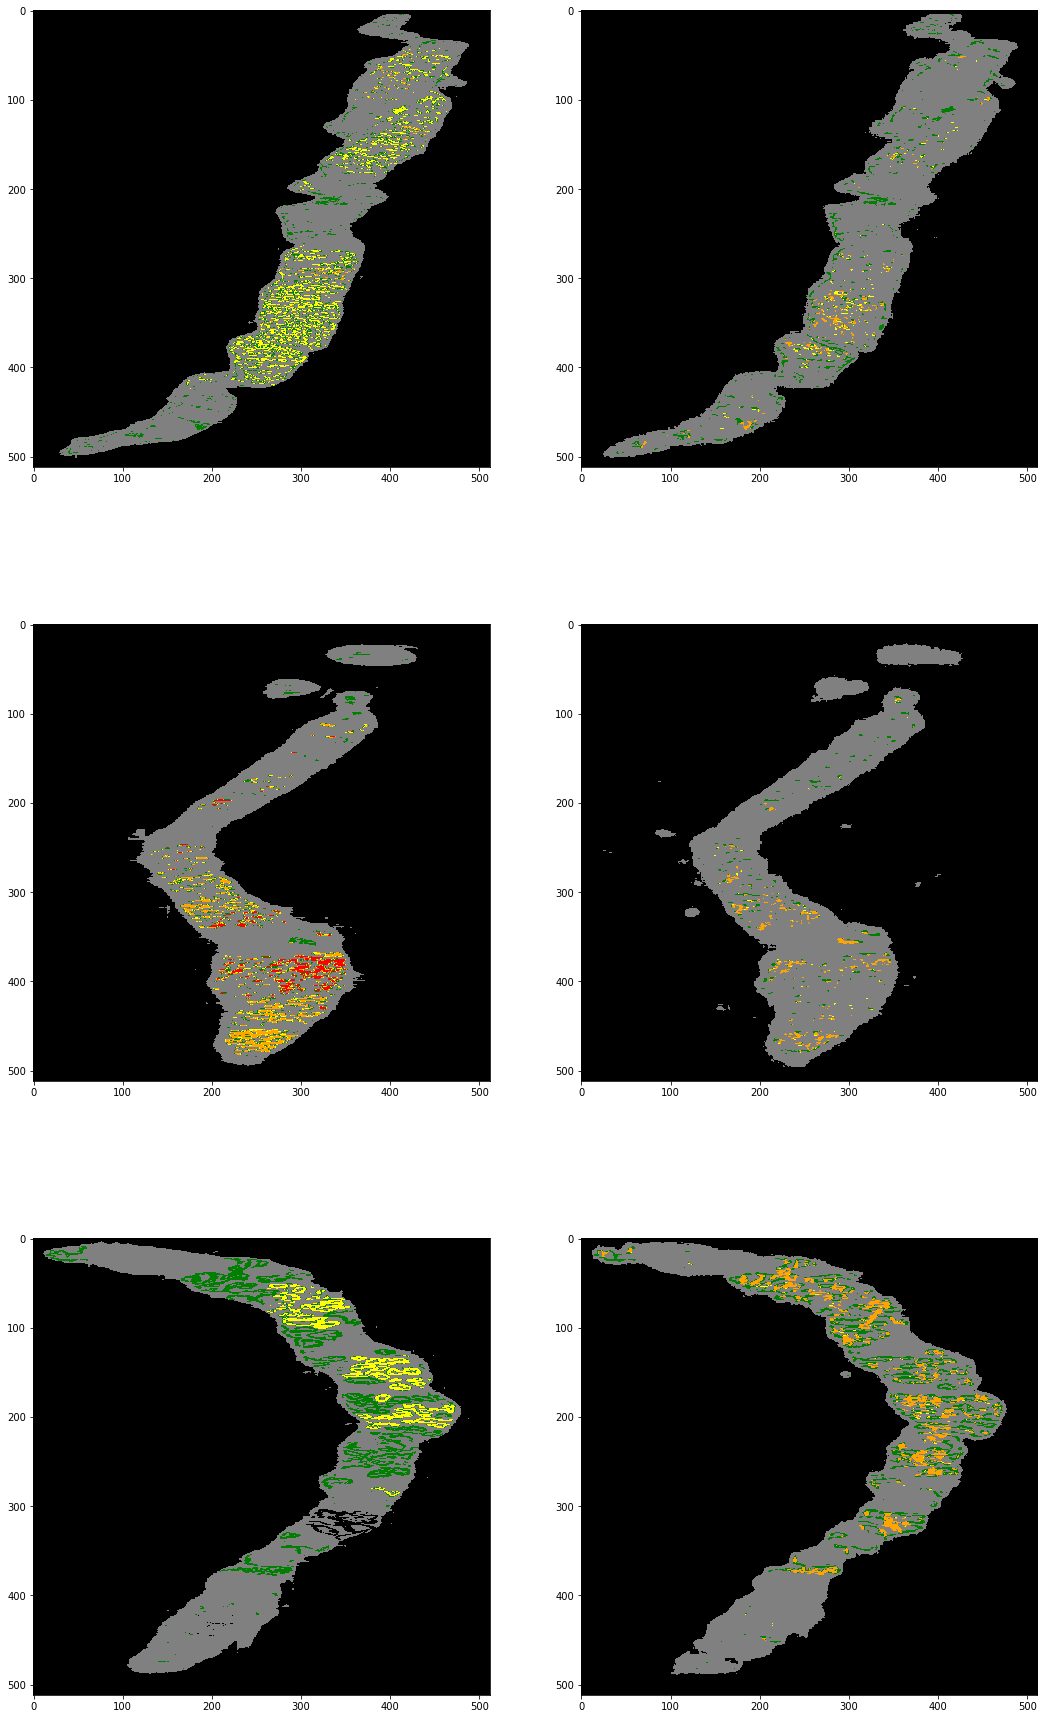

In [ ]:
# compare data for all grades from r center with only  the severious grade(5)
# show trainning loss vs epoch plot// running_loss for test set//  label mask vs predict mask visulazation 
#1) all grades from r center 20 epoch
train(trainr_loader,20,3,validr_loader)

Epoch 0,running_Loss 0.3510689646862447
Epoch 1,running_Loss 0.2699713515266776
Epoch 2,running_Loss 0.22493604988604785
Epoch 3,running_Loss 0.21353372996114195
Epoch 4,running_Loss 0.21344463819265366
Epoch 5,running_Loss 0.21213448605313898
Epoch 6,running_Loss 0.2144549038670957
Epoch 7,running_Loss 0.20635486936941744
Epoch 8,running_Loss 0.2033021745607257
Epoch 9,running_Loss 0.19882818738371133
Epoch 10,running_Loss 0.20261558432877064
Epoch 11,running_Loss 0.19428139094822108
Epoch 12,running_Loss 0.1921020050048828
Epoch 13,running_Loss 0.18817919089086355
Epoch 14,running_Loss 0.19011126187816263
Epoch 15,running_Loss 0.18487054322846233
Epoch 16,running_Loss 0.18430796687491238
Epoch 17,running_Loss 0.1813516716565937
Epoch 18,running_Loss 0.17996276176720857
Epoch 19,running_Loss 0.18200351009890436
Epoch 20,running_Loss 0.1992529408596456
Epoch 21,running_Loss 0.18672952252812683
Epoch 22,running_Loss 0.1783004265744239
Epoch 23,running_Loss 0.17935725367069244
Epoch 24,r

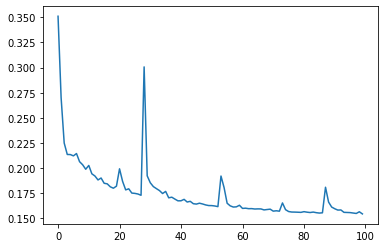

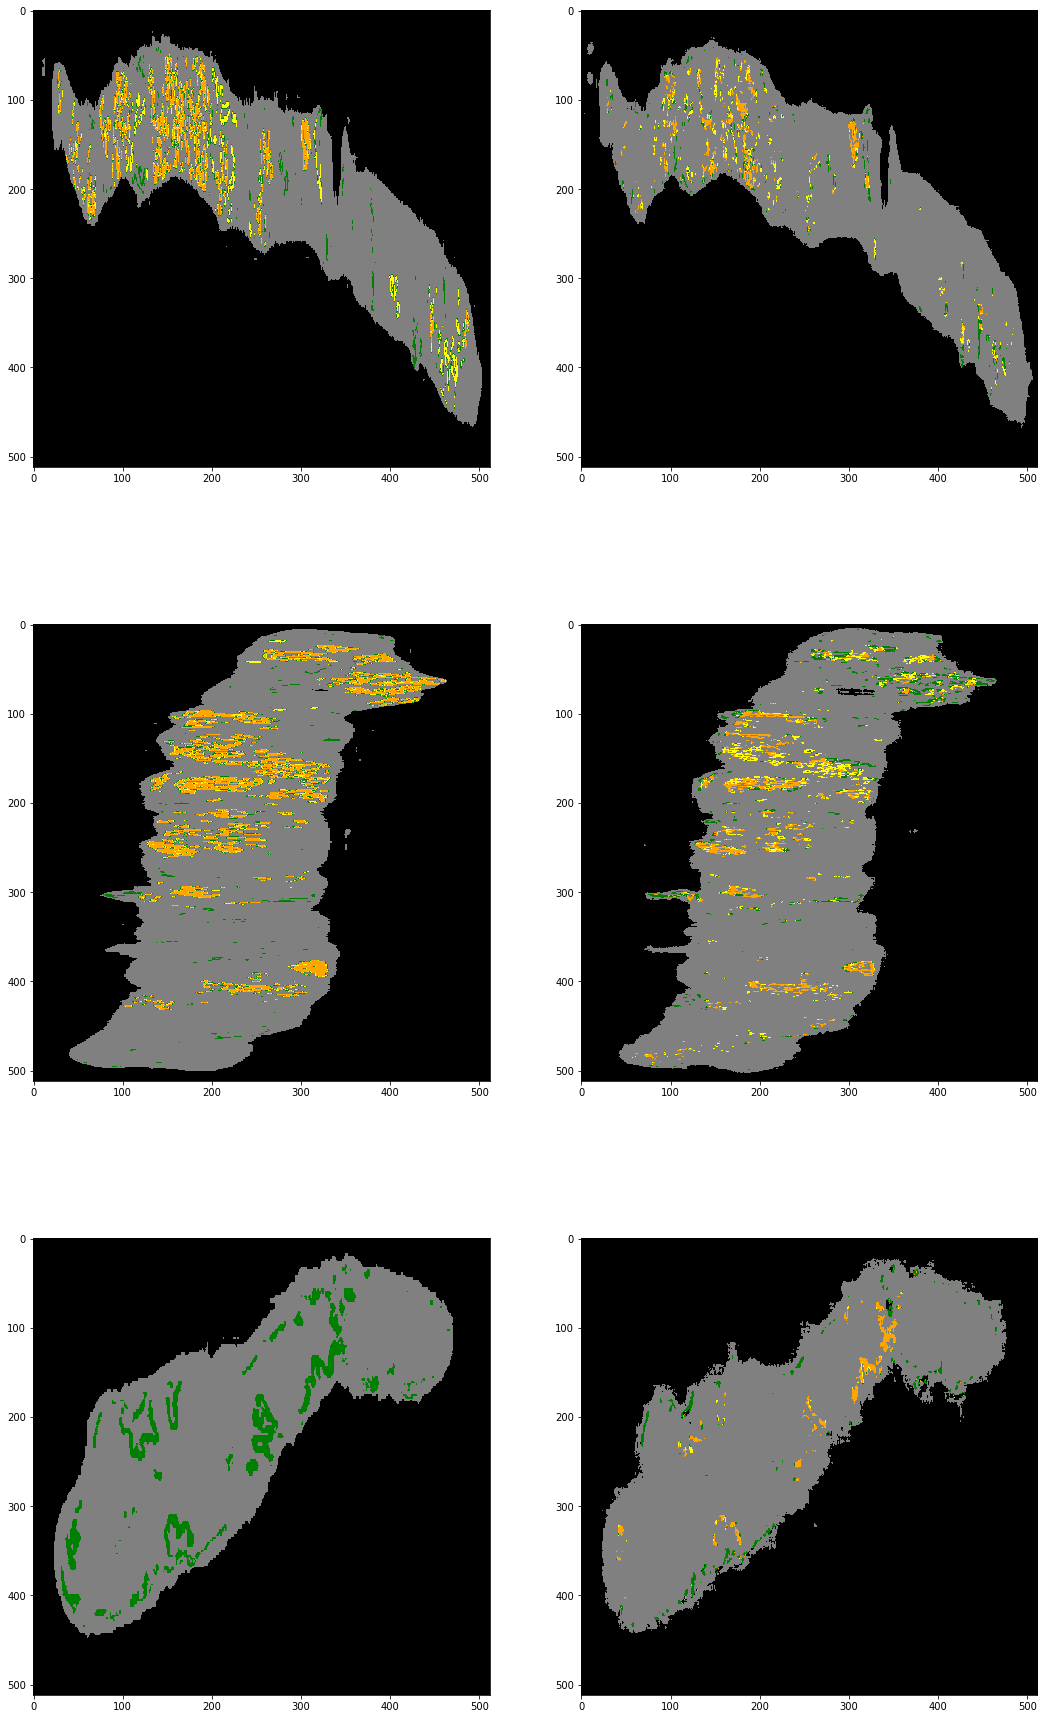

In [ ]:
#2) all grades from r center 100 epoch, we can see test loss impove  from 0.21492987511807987 to 0.1933531503291718
train(trainr_loader,100,3,validr_loader)

Epoch 0,running_Loss 3.1486849899031224
Epoch 1,running_Loss 0.24928160894289614
Epoch 2,running_Loss 0.2454806925728917
Epoch 3,running_Loss 0.24122023769468068
Epoch 4,running_Loss 0.23477117234095932
Epoch 5,running_Loss 0.23210586096718908
Epoch 6,running_Loss 0.2345460224673152
Epoch 7,running_Loss 0.23276409842073917
Epoch 8,running_Loss 0.22572415105998517
Epoch 9,running_Loss 0.21107652658224105
Epoch 10,running_Loss 0.20343260257691145
Epoch 11,running_Loss 0.20291888506338002
Epoch 12,running_Loss 0.19528108240291475
Epoch 13,running_Loss 0.19841358350962401
Epoch 14,running_Loss 0.2609179240167141
Epoch 15,running_Loss 0.22675338450819255
Epoch 16,running_Loss 0.22793823636695743
Epoch 17,running_Loss 0.20903890427201988
Epoch 18,running_Loss 0.19773342260718346
Epoch 19,running_Loss 0.19310480049066245
Epoch 20,running_Loss 0.18507480765134096
Epoch 21,running_Loss 0.19019010639563202
Epoch 22,running_Loss 0.19795423724874855
Epoch 23,running_Loss 0.18322747601009906
Epoch 

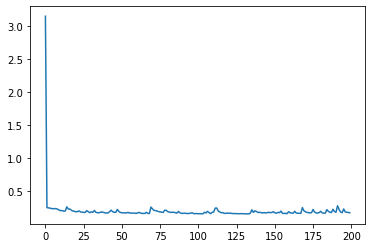

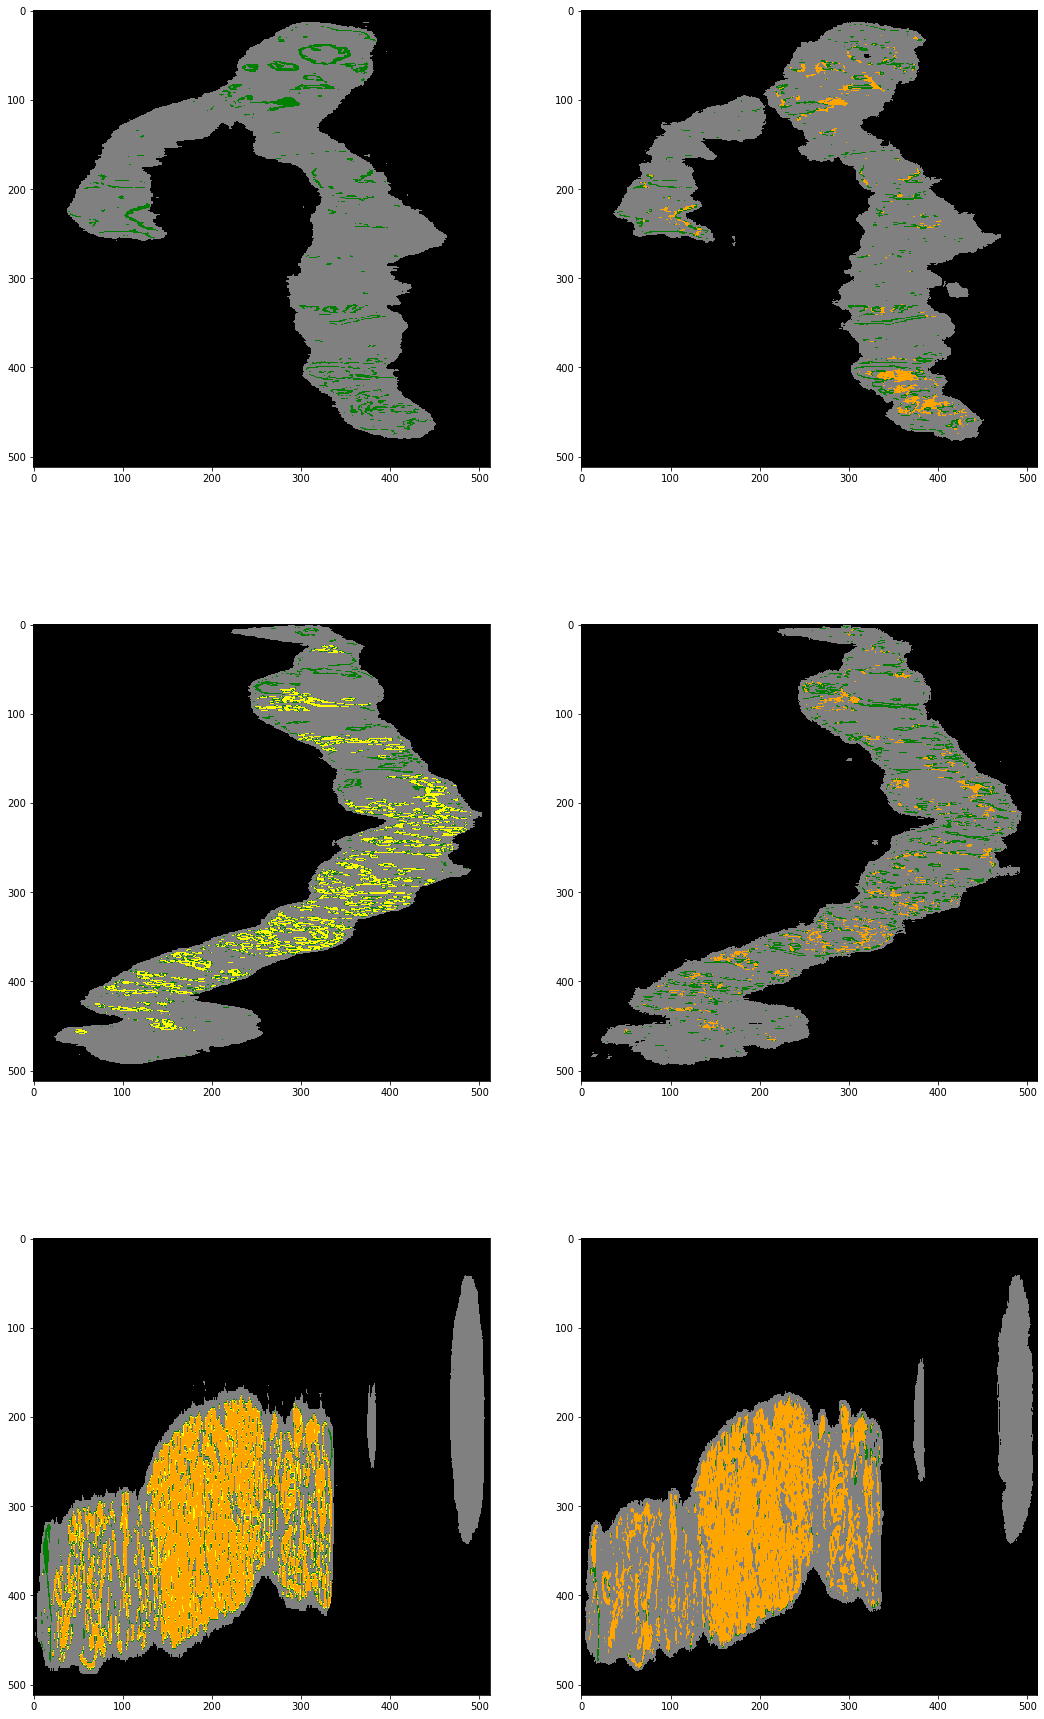

In [ ]:
# all grades from r center 200 epoch seems overfitted
train(trainr_loader,200,3,validr_loader)

Epoch 0,running_Loss 0.3821108402738433
Epoch 1,running_Loss 0.33018695682874605
Epoch 2,running_Loss 0.2744048811510762
Epoch 3,running_Loss 0.24379601777836496
Epoch 4,running_Loss 0.23204091693278542
Epoch 5,running_Loss 0.2267113188629452
Epoch 6,running_Loss 0.22123203540213127
Epoch 7,running_Loss 0.218421908180496
Epoch 8,running_Loss 0.23579966359968874
Epoch 9,running_Loss 0.21825389509549156
Epoch 10,running_Loss 0.21098457349085586
Epoch 11,running_Loss 0.20576816310727375
Epoch 12,running_Loss 0.21773483274945085
Epoch 13,running_Loss 0.2059249975815168
Epoch 14,running_Loss 0.21376331992972936
Epoch 15,running_Loss 0.2114462858854302
Epoch 16,running_Loss 0.20305348053203578
Epoch 17,running_Loss 0.1992374109181564
Epoch 18,running_Loss 0.19817392732484335
Epoch 19,running_Loss 0.20013376027036506
running_Loss 0.22978033640793538


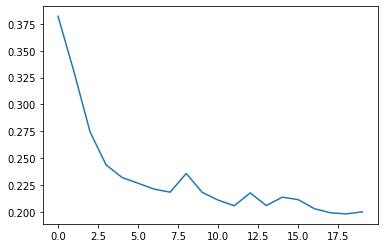

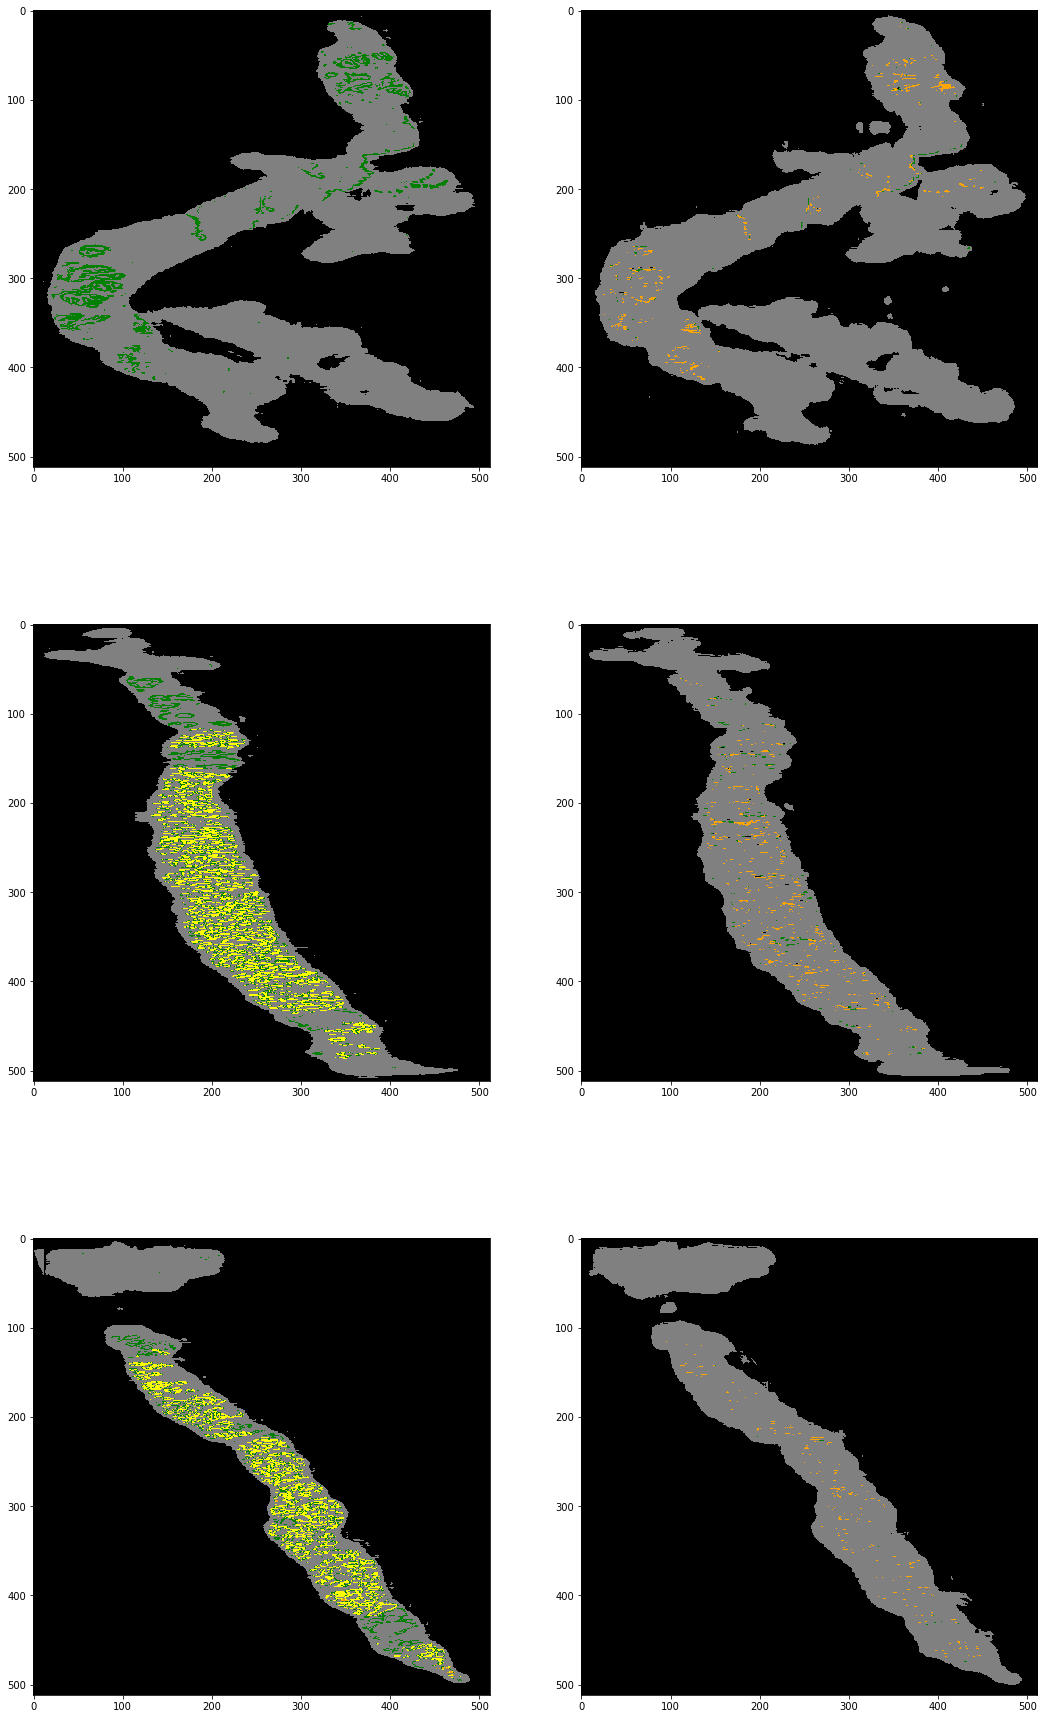

In [ ]:
# only grade 5 from r center 20 epoch, test loss 0.22978033640793538 is a little higher than all grades 0.21492987511807987
# that is probably because test data is similar to the data from all grades.
train(train5_loader,20,3,validr_loader)

In [21]:
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix


In [18]:
 # define dice loss
 def dice_loss(y_pred,y_true):
    numerator = 2 * torch.sum(y_pred * y_true)
    
    denominator = torch.sum(y_pred + y_true)
    return 1 - (numerator + 1) / (denominator + 1) 
def dice_coef_multilabel(y_pred, y_true, numLabels=6):
    dice=0
    for index in range(numLabels):
        dice -= dice_loss(y_pred[index,:,:], y_true[0,:,:])
    return dice        

Epoch 0,running_Loss 0.3554212566316128
Epoch 1,running_Loss 0.26383587965741756
Epoch 2,running_Loss 0.22060557116568089
Epoch 3,running_Loss 0.2263014306910336
Epoch 4,running_Loss 0.22056920264288782
Epoch 5,running_Loss 0.20550033329240977
Epoch 6,running_Loss 0.19970788789726793
Epoch 7,running_Loss 0.22782571268454194
Epoch 8,running_Loss 0.19942204638943076
Epoch 9,running_Loss 0.1949260643608868
Epoch 10,running_Loss 0.1945352027863264
Epoch 11,running_Loss 0.1913964276816696
Epoch 12,running_Loss 0.18594037117064
Epoch 13,running_Loss 0.18562424094974994
Epoch 14,running_Loss 0.18483349522948264
Epoch 15,running_Loss 0.17855071860551835
Epoch 16,running_Loss 0.18711199347302318
Epoch 17,running_Loss 0.17689793640188872
Epoch 18,running_Loss 0.1752085881177336
Epoch 19,running_Loss 0.1776490621045232


<function matplotlib.pyplot.show>

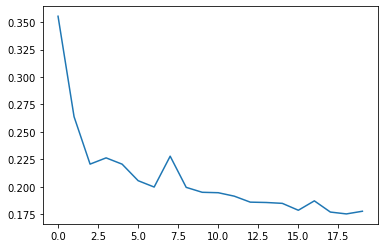

In [ ]:
# train with NLLloss for all grade 20 epoch, same as before, but will test with dice loss in next cell
model = UNet(in_channels=3,
             out_channels=64,
             n_class=6,
             kernel_size=3,
             padding=1,
             stride=1)
# Create 6-class segmentation dummy image and target
nb_classes = 6
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
Loss=[]
for epoch in range(20):  # loop over the dataset multiple times

    running_loss = 0.
    for x,y in trainr_loader:

       y = y.type(torch.LongTensor)
       if torch.cuda.is_available():

          model = model.to('cuda')
          x = x.to('cuda')
          y = y.to('cuda')
       optimizer.zero_grad()
       output = model(x)
    #y = y.type(torch.LongTensor)
       loss = criterion(output, y)
    #loss=diceLoss(diceLoss,y,output,epsilon=1,p=False)
       loss.backward()
       optimizer.step()
     
      #print('Epoch {}, Loss {}'.format(epoch, loss.item()))
        # print statistics
       running_loss += loss.item()
       #print('Epoch {}, Loss {}'.format(epoch, loss.item()))
    
        
    print( 'Epoch {},running_Loss {}'.format(epoch,running_loss/len(trainr_loader))) 
    
    Loss.append(running_loss/len(trainr_loader))    
plt.plot(Loss)
plt.show


In [ ]:
 # evaluation metrics: accuary, recall,precision, f1_score, confusion metrics, dice loss
 # compare NLLloss with dice loss, dice loss has higher number, which make sense since it consider overlap region.
import numpy 
running_accuracy=0
running_loss=0
running_dloss=0
running_precision=0
running_recall =0
running_f1=0
running_con=np.zeros((6,6))
for x,y in validr_loader:

       y = y.type(torch.LongTensor)
       if torch.cuda.is_available():

          model = model.to('cuda')
          x = x.to('cuda')
        
       output = model(x)
    
       y_true=y[-1].numpy().reshape(-1)
       
       f=output[0].cpu().detach().numpy() 
       f=f.argmax(axis=0)
       y_label=f.reshape(-1)
     
       accuracy = accuracy_score(y_true, y_label)
  
       precision = precision_score(y_true, y_label,average='weighted')

       recall = recall_score(y_true, y_label,average='weighted')

       f1 = f1_score(y_true, y_label,average='weighted')

       loss=dice_loss(output[0].cpu().detach(),y)
       dloss=dice_coef_multilabel(output[0].cpu().detach(),y,6)
      
     
     
       running_loss += loss.item()
       running_dloss += dloss.item()
       running_accuracy += accuracy
       running_precision += precision
       running_recall += recall
       running_f1 += f1
      
    
print( 'running_accuracy {}'.format(running_accuracy/len(validr_loader)))      
print( 'running_Loss {}'.format(running_loss/len(validr_loader)))
print( 'running_dLoss {}'.format(running_dloss/len(validr_loader)))
print( 'running_precision {}'.format(running_precision/len(validr_loader))) 
print( 'running_recall {}'.format(running_recall/len(validr_loader))) 
print( 'running_f1 {}'.format(running_f1/len(validr_loader))) 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


running_accuracy 0.9415276513311076
running_Loss 0.780702619702358
running_dLoss -0.8138539611265577
running_precision 0.9373069009303844
running_recall 0.9415276513311076
running_f1 0.9340710889495392


Accuracy: 0.960995
Precision: 0.950707
Recall: 0.960995
f1_score: 0.954715


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[223114   1676      0      0      0      0]
 [   864  27963     29     13    399      0]
 [     0   1004     46     17    172      0]
 [     0    731     27     10    261      0]
 [     0    895     49     15    786      0]
 [     0    858    169     31   3015      0]]
loss: 0.8674465417861938
Accuracy: 0.954990
Precision: 0.963494


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Recall: 0.954990
f1_score: 0.953547
[[216381   2792     15      0      0      0]
 [  2328  32749    284     57    490      0]
 [     0   3575   1215    149   2109      0]
 [     0      0      0      0      0      0]
 [     0      0      0      0      0      0]
 [     0      0      0      0      0      0]]
loss: 0.8565114140510559
Accuracy: 0.849621
Precision: 0.820292
Recall: 0.849621
f1_score: 0.815052
[[160317   2277     17     36      5      0]
 [ 12958  61811     49    129     97      0]
 [     0   4836     48    112     53      0]
 [     0   4538     33    142     40      0]
 [     0  13360    273    608    405      0]
 [     0      0      0      0      0      0]]
loss: 0.47074204683303833


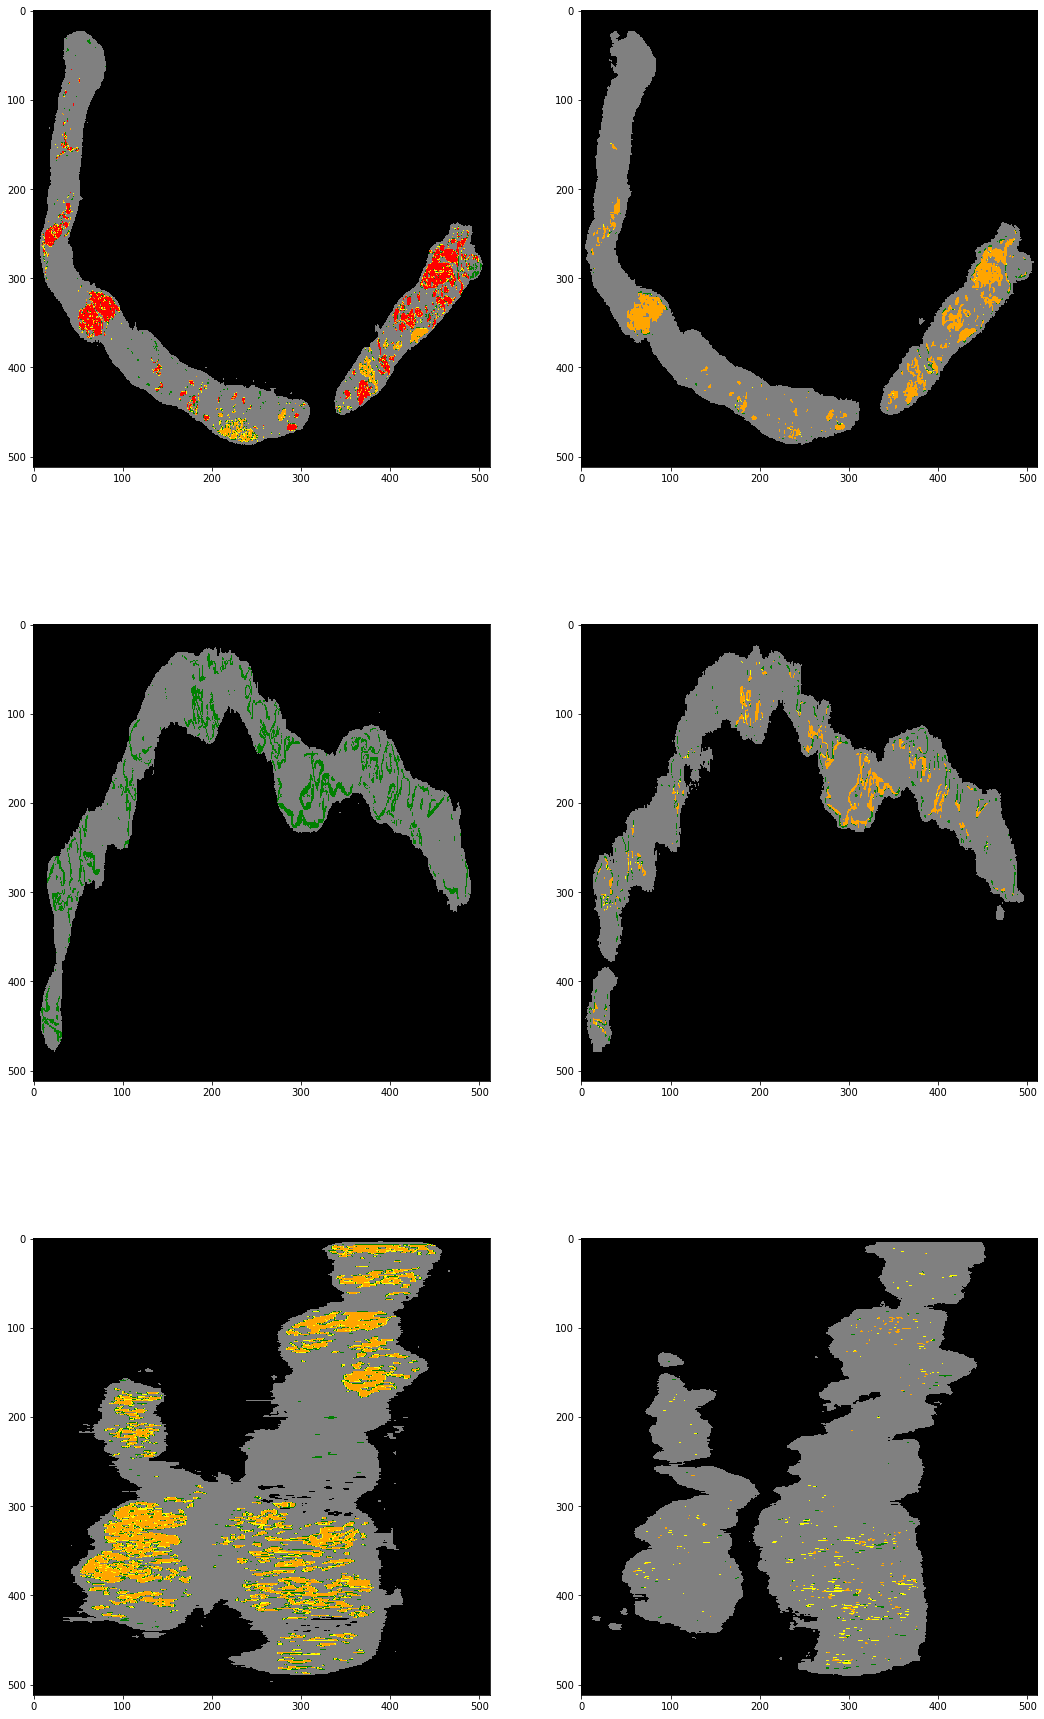

In [ ]:
  # show 3 sample of test set label mask,predict mask,accuary,recall, precision,f1_score,confusion metrics,dice loss
  
  f, ax = plt.subplots(3,2, figsize=(18,32))
  m=iter(validr_loader)
  for i in range(3):
    x,y=next(m)
    #y = y.type(torch.LongTensor)
    cmap = matplotlib.colors.ListedColormap(['black', 'gray', 'green', 'yellow', 'orange', 'red'])
    ax[i, 0].imshow(y[-1],cmap=cmap,interpolation='nearest', vmin=0, vmax=5) 
   # plt.show()
    
    if torch.cuda.is_available():
          model = model.to('cuda')
          x = x.to('cuda')
          #y = y.to('cuda')
    output = model(x)
    #
    f=output[0].cpu().detach().numpy() 
    f=f.argmax(axis=0)
   
    cmap = matplotlib.colors.ListedColormap(['black', 'gray', 'green', 'yellow', 'orange', 'red'])
    ax[i, 1].imshow(f,cmap=cmap,interpolation='nearest', vmin=0, vmax=5)
    
    y_true=y[-1].numpy().reshape(-1)
    y_label=f.reshape(-1)
    
       # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(y_true, y_label)
    print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
    precision = precision_score(y_true, y_label,average='weighted')
    print('Precision: %f' % precision)
# recall: tp / (tp + fn)
    recall = recall_score(y_true, y_label,average='weighted')
    print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_true, y_label,average='weighted')
    print('f1_score: %f' % f1)

    con=confusion_matrix(y_true, y_label,labels=[0,1,2,3,4,5])
    print(con)
     
    loss=dice_loss(output[0].cpu().detach(),y)
    print('loss: {}'.format(loss))
  